In [648]:
import pandas as pd
pd.options.display.float_format = '{:,.4f}'.format
pd.options.display.max_rows = 100
pd.options.display.max_columns = 40
import numpy as np
import os,random, math
from tqdm import tqdm
from copy import deepcopy
from collections import Counter

# Visualization
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import font_manager, rc
plt.rcParams['font.family'] = 'NanumGothic'
import platform
if platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)
else:    
    rc('font', family='AppleGothic')

matplotlib.rcParams['axes.unicode_minus'] = False

# from dataprep.eda import plot, plot_correlation, plot_missing

import plotly 
import plotly.express as px
# from plotly import tools, subplots
# import plotly.offline as py
# py.init_notebook_mode(connected=True)
# from plotly.offline import init_notebook_mode, iplot
# import plotly.graph_objs as go
# import plotly.express as px

# Warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')
# row 생략 없이 출력
pd.set_option('display.max_rows', None)
# col 생략 없이 출력
pd.set_option('display.max_columns', None)
from sklearn.metrics import mean_absolute_error

In [535]:
rawtest = pd.read_csv("/Users/seungji/Desktop/Dacon/Daesamanlap/ProcessedData/merged_test.csv")
rawtrain = pd.read_csv("/Users/seungji/Desktop/Dacon/Daesamanlap/ProcessedData/merged_train.csv")

In [536]:
test = pd.read_csv("/Users/seungji/Desktop/Dacon/Daesamanlap/ProcessedData/merged_test.csv")
train = pd.read_csv("/Users/seungji/Desktop/Dacon/Daesamanlap/ProcessedData/merged_train.csv")

In [537]:
# merged_ data에서 drop해야 할 단지코드
print(train.shape, test.shape)
train = train.loc[~train.단지코드.isin(['C1095', 'C2051', 'C1218', 'C1894', 'C2483', 'C1502', 'C1988']),]
test = test.loc[~test.단지코드.isin(['C2335', 'C1327', 'C2675'])]
print(train.shape, test.shape)

(2896, 34) (1008, 33)
(2896, 34) (1008, 33)


In [538]:
print(len(set(train.단지코드)), len(set(test.단지코드)))

414 147


In [539]:
train.at[range(1481,1487),"총세대수"]=969
train.at[range(1624,1632),"총세대수"]=969
train.at[range(1481,1487),"공가수"]=9
train.at[range(1624,1632),"공가수"]=9

train.at[range(1753,1757),"총세대수"]=1047
train.at[range(1810,1812),"총세대수"]=1047
train.at[range(1753,1757),"공가수"]=31
train.at[range(1810,1812),"공가수"]=31
train.at[range(1753,1757),"등록차량수"]=1214
train.at[range(1810,1812),"등록차량수"]=1214
train.at[range(1753,1757),"버스정류장"]=4
train.at[range(1810,1812),"버스정류장"]=4

In [540]:
train=train.drop_duplicates(keep='first')
test=test.drop_duplicates(keep='first')

In [541]:
print("\n...Before preprocessing")
print(train.shape, test.shape)

# 상가비율 column 추가
train_cls = pd.concat([train[['단지코드']], pd.get_dummies(train[['임대건물구분']])], axis=1).groupby('단지코드').sum()
tot = train_cls['임대건물구분_상가']+train_cls['임대건물구분_아파트']
train_cls['상가비율'] = train_cls['임대건물구분_상가']/tot
train = pd.merge(train,train_cls[['상가비율']].reset_index(),on='단지코드')

test_cls = pd.concat([test[['단지코드']], pd.get_dummies(test[['임대건물구분']])], axis=1).groupby('단지코드').sum()
tot = test_cls['임대건물구분_상가']+test_cls['임대건물구분_아파트']
test_cls['상가비율'] = test_cls['임대건물구분_상가']/tot
test = pd.merge(test,test_cls[['상가비율']].reset_index(),on='단지코드')

# 세대당_가능주차면수 column 추기
train['세대당_가능주차면수'] = train['단지내주차면수']/train['총세대수']
test['세대당_가능주차면수'] = test['단지내주차면수']/test['총세대수']

# 공가수비율 column 추가
train['공가수비율']= train.공가수/train.총세대수 
test['공가수비율']= test.공가수/test.총세대수 

# 대형전용면적 column 추가
level = 85
train['대형전용면적'] = 0
train.loc[train.전용면적>level, '대형전용면적'] = 1
train.loc[train.전용면적<=level, '대형전용면적'] = 0

test['대형전용면적'] = 0
test.loc[test.전용면적>level, '대형전용면적'] = 1
test.loc[test.전용면적<=level, '대형전용면적'] = 0

# check
print("\n...After preprocessing")
print(train.shape, test.shape)


...Before preprocessing
(2577, 34) (936, 33)

...After preprocessing
(2577, 38) (936, 37)


## 자격유형


In [542]:
dic = {'1': 'A' ,'2':['C','F','G'],'3':['B','H','I'],'4':['J'],
       '5':['L',"M","N","O"],'6':["E","K"],'7':'D'}

In [543]:
def mapping_by_key(dic, x):
    for i in dic.keys():
        if x in dic[i]:
            return int(i)

In [544]:
train['자격유형_카테고리'] = train['자격유형'].apply(lambda x : mapping_by_key(dic, x))
train['자격유형_카테고리'] = train['자격유형_카테고리'].astype(object)
test['자격유형_카테고리'] = test['자격유형'].apply(lambda x : mapping_by_key(dic, x))
test['자격유형_카테고리'] = test['자격유형_카테고리'].astype(object)
train= train.drop(columns="자격유형")
test= test.drop(columns="자격유형")

## 공급유형

In [545]:
train.loc[train.공급유형.isin(['공공임대(5년)', '공공임대(10년)']), '공급유형'] = '공공임대(단기)'
test.loc[test.공급유형.isin(['공공임대(5년)', '공공임대(10년)']), '공급유형'] = '공공임대(단기)'

In [546]:
train.shape, test.shape

((2577, 38), (936, 37))

In [547]:
data = train.drop(columns=['공급유형','자격유형_카테고리','전용면적','임대건물구분',
                           '전용면적별세대수','대형전용면적','자격유형_카테고리',
                           '임대보증금','임대료'])
data = data.drop_duplicates()

In [548]:
data.shape

(418, 30)

## 1차원

### train

In [549]:
sample = pd.DataFrame(train.groupby(['단지코드','공급유형']).sum()['전용면적별세대수']).reset_index()

In [550]:
for i in sample.공급유형.unique():
    data[str(i)]=0

In [551]:
for i in sample.index:
    code = sample.loc[i,'단지코드']
    col = sample.loc[i,'공급유형']
    val = sample.loc[i,'전용면적별세대수']
    ind = data[data['단지코드']==code].index
    data.loc[ind,col] = val

In [552]:
sample = train.groupby('단지코드').mean()[['임대료','임대보증금']].reset_index()
sample.head()

,단지코드,임대료,임대보증금
0,C1000,"121,064.2857","13,203,571.4286"
1,C1004,"877,964.1872","10,383,958.6857"
2,C1005,"222,046.6667","17,107,666.6667"
3,C1013,"134,726.0000","24,924,800.0000"
4,C1014,"160,488.5714","23,894,000.0000"


In [553]:
for i in sample.index:
    code = sample.loc[i,'단지코드']
    val1 = sample.loc[i,'임대료']
    val2 = sample.loc[i,'임대보증금']
    ind = data[data['단지코드']==code].index
    data.loc[ind,'임대료'] = val1
    data.loc[ind,'임대보증금'] = val2

In [554]:
sample = pd.DataFrame(train.groupby(['단지코드','자격유형_카테고리']).sum()['전용면적별세대수']).reset_index()
sample.head()

,단지코드,자격유형_카테고리,전용면적별세대수
0,C1000,1,566
1,C1004,2,504
2,C1004,7,13
3,C1005,1,1144
4,C1013,1,1308


In [555]:
for i in sample.index:
    code = sample.loc[i,'단지코드']
    col = sample.loc[i,'자격유형_카테고리']
    val = sample.loc[i,'전용면적별세대수']
    ind = data[data['단지코드']==code].index
    data.loc[ind,col] = val

In [556]:
data=data.fillna(0)

In [557]:
sample = pd.DataFrame(train.groupby('단지코드')['대형전용면적'].sum()).reset_index()
sample.head()

,단지코드,대형전용면적
0,C1000,0
1,C1004,1
2,C1005,0
3,C1013,0
4,C1014,0


In [558]:
data

,단지코드,총세대수,지역,공가수,지하철역,버스정류장,단지내주차면수,등록차량수,단지명,도로명주소,연면적,위도,경도,subway_name,subway_dist,환승역 수,총인구수,세대당_인구,남/여비율,남/여_0~19세,남/여_20~39세,남/여_40~69세,남/여_70세이상,0~19세_비율,20~39세_비율,40~69세_비율,70세이상_비율,상가비율,세대당_가능주차면수,공가수비율,국민임대,영구임대,임대상가,공공임대(단기),장기전세,행복주택,공공임대(분납),공공분양,공공임대(50년),임대료,임대보증금,1,2,7,3,6,4,5
0,C2515,545,경상남도,17.0000,0.0000,3.0000,624.0000,205.0000,미수휴먼시아,경상남도 통영시 미우지해안로 107,"1,213.8700",128.3965,34.8242,다대포해수욕장역,0.6117,1,"11,129.0000",2.3000,0.9700,1.7612,1.0366,0.9840,0.5888,0.1956,0.1850,0.5221,0.0972,0.0000,1.1450,0.0312,545,0,0,0,0,0,0,0,0,"139,557.1429","16,787,142.8571",545.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
7,C1407,1216,대전광역시,13.0000,1.0000,1.0000,"1,285.0000","1,064.0000",도안 휴먼시아 4단지,대전광역시 유성구 상대로 40,"4,636.4100",127.3374,36.3466,유성온천역,0.0082,1,"45,840.0000",2.4200,0.9200,2.1671,0.9294,0.8716,0.6995,0.2288,0.2761,0.4425,0.0527,0.0000,1.0567,0.0107,914,0,0,0,0,0,0,0,0,"165,956.2500","25,984,375.0000",914.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
15,C1945,755,경기도,6.0000,1.0000,3.0000,734.0000,730.0000,호평마을 주공휴먼시아,경기도 남양주시 늘을3로 8,"6,017.7600",127.2408,37.6584,평내호평역,0.0063,1,"57,499.0000",2.6500,0.9500,1.9906,0.9644,0.9377,0.6974,0.2349,0.2390,0.4468,0.0793,0.0000,0.9722,0.0079,635,0,0,0,0,0,0,0,0,"200,914.0000","24,060,600.0000",0.0000,0.0000,0.0000,635.0000,0.0000,0.0000,0.0000
20,C1470,696,전라북도,14.0000,0.0000,2.0000,645.0000,553.0000,장신휴먼시아1단지,전라북도 익산시 오산면 선화로4길 66,"6,611.9000",126.9312,35.9467,연산역,0.3785,2,"7,783.0000",2.0000,0.9800,1.8224,1.1859,1.0494,0.6716,0.1429,0.1798,0.4903,0.1871,0.0000,0.9267,0.0201,696,0,0,0,0,0,0,0,0,"120,150.0000","17,722,750.0000",696.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
24,C1898,566,전라북도,9.0000,0.0000,6.0000,517.0000,415.0000,장신휴먼시아2단지,전라북도 익산시 오산면 선화로4길 24-9,"6,749.2000",126.9320,35.9486,연산역,0.3766,2,"7,783.0000",2.0000,0.9800,1.8224,1.1859,1.0494,0.6716,0.1429,0.1798,0.4903,0.1871,0.0000,0.9134,0.0159,566,0,0,0,0,0,0,0,0,"119,148.3333","17,422,333.3333",566.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2557,C2586,90,제주특별자치도,7.0000,0.0000,3.0000,66.0000,57.0000,서귀포서홍행복주택,제주특별자치도 서귀포시 장수로 115,67.9800,126.5554,33.2557,평동역,1.8812,1,"7,195.5000",2.1050,1.0000,1.8219,1.0350,1.0388,0.7167,0.2102,0.2183,0.4603,0.1112,0.0000,0.7333,0.0778,0,0,0,0,0,90,0,0,0,"111,180.0000","26,160,000.0000",0.0000,0.0000,0.0000,0.0000,0.0000,90.0000,0.0000
2562,C2035,492,강원도,24.0000,0.0000,1.0000,521.0000,246.0000,춘천우두 국민임대 3단지,강원도 춘천시 우두1길 40,59.4100,127.7372,37.9097,춘천역,0.0324,1,"23,027.0000",2.4100,1.0100,2.2876,1.1173,0.9914,0.6951,0.1979,0.2587,0.4337,0.1096,0.0000,1.0589,0.0488,492,0,0,0,0,0,0,0,0,"158,800.0000","15,730,000.0000",492.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2567,C2020,40,부산광역시,7.0000,1.0000,2.0000,25.0000,19.0000,부산용호(행복주택),부산광역시 남구 동명로 183,152.2900,129.1169,35.1187,남천역,0.0250,1,"20,603.2500",2.3900,0.9450,1.7453,1.0855,0.9078,0.7505,0.1699,0.2025,0.4957,0.1318,0.0000,0.6250,0.1750,0,0,0,0,0,40,0,0,0,"135,976.6667","28,133,333.3333",0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,40.0000
2570,C2437,90,충청북도,12.0000,0.0000,1.0000,30.0000,16.0000,제천청전(공공실버),충청북도 제천시 용두천로40길 28,88.8600,128.2186,37.1561,여주역,0.6035,1,"9,989.0000",2.3000,0.9700,1.8302,1.0634,0.9768,0.6312,0.1887,0.2314,0.4785,0.1014,0.0000,0.3333,0.1333,0,90,0,0,0,0,0,0,0,"107,530.0000","10,346,000.0000",0.0000,90.0000,0.0000,0.0000,0.0000,0.0000,0.0000


In [559]:
tr=pd.merge(data, sample, on="단지코드", how="inner")

### test

In [560]:
print(len(set(test.단지코드)))
dat = test.drop(columns=['공급유형','자격유형_카테고리','전용면적','임대건물구분',
                           '전용면적별세대수','대형전용면적','자격유형_카테고리',
                           '임대보증금','임대료'])
dat = dat.drop_duplicates()
dat.shape

147


(147, 29)

In [561]:
sample = pd.DataFrame(test.groupby(['단지코드','공급유형']).sum()['전용면적별세대수']).reset_index()
sample.head()

,단지코드,공급유형,전용면적별세대수
0,C1003,행복주택,480
1,C1006,영구임대,1475
2,C1006,임대상가,13
3,C1016,국민임대,643
4,C1019,국민임대,321


In [562]:
for i in sample.공급유형.unique():
    dat[str(i)]=0

In [563]:
for i in sample.index:
    code = sample.loc[i,'단지코드']
    col = sample.loc[i,'공급유형']
    val = sample.loc[i,'전용면적별세대수']
    ind = dat[dat['단지코드']==code].index
    dat.loc[ind,col] = val

In [564]:
sample = test.groupby('단지코드').mean()[['임대료','임대보증금']].reset_index()
sample.head()

,단지코드,임대료,임대보증금
0,C1003,"115,875.0000","22,650,000.0000"
1,C1006,"2,333,169.1152","17,549,529.3035"
2,C1016,"228,010.0000","24,026,750.0000"
3,C1019,"126,430.0000","14,857,500.0000"
4,C1030,"214,216.6667","51,413,333.3333"


In [565]:
for i in sample.index:
    code = sample.loc[i,'단지코드']
    val1 = sample.loc[i,'임대료']
    val2 = sample.loc[i,'임대보증금']
    ind = dat[dat['단지코드']==code].index
    dat.loc[ind,'임대료'] = val1
    dat.loc[ind,'임대보증금'] = val2

In [566]:
sample = pd.DataFrame(test.groupby(['단지코드','자격유형_카테고리']).sum()['전용면적별세대수']).reset_index()
sample.head()

,단지코드,자격유형_카테고리,전용면적별세대수
0,C1003,4,480
1,C1006,2,1459
2,C1006,7,29
3,C1016,1,643
4,C1019,1,321


In [567]:
for i in sample.index:
    code = sample.loc[i,'단지코드']
    col = sample.loc[i,'자격유형_카테고리']
    val = sample.loc[i,'전용면적별세대수']
    ind = dat[dat['단지코드']==code].index
    dat.loc[ind,col] = val

In [568]:
dat=dat.fillna(0)

In [569]:
sample = pd.DataFrame(test.groupby('단지코드')['대형전용면적'].sum()).reset_index()
sample.head()

,단지코드,대형전용면적
0,C1003,0
1,C1006,1
2,C1016,0
3,C1019,0
4,C1030,0


In [570]:
tst=pd.merge(dat, sample, on="단지코드", how="inner")

In [571]:
tr.shape

(418, 49)

# 은영이랑 달라지는 부분 

In [572]:
tr.columns

Index([       '단지코드',        '총세대수',          '지역',         '공가수',
              '지하철역',       '버스정류장',     '단지내주차면수',       '등록차량수',
               '단지명',       '도로명주소',         '연면적',          '위도',
                '경도', 'subway_name', 'subway_dist',       '환승역 수',
              '총인구수',      '세대당_인구',       '남/여비율',   '남/여_0~19세',
        '남/여_20~39세',  '남/여_40~69세',   '남/여_70세이상',    '0~19세_비율',
         '20~39세_비율',   '40~69세_비율',    '70세이상_비율',        '상가비율',
        '세대당_가능주차면수',       '공가수비율',        '국민임대',        '영구임대',
              '임대상가',    '공공임대(단기)',        '장기전세',        '행복주택',
          '공공임대(분납)',        '공공분양',   '공공임대(50년)',         '임대료',
             '임대보증금',             1,             2,             7,
                   3,             6,             4,             5,
            '대형전용면적'],
      dtype='object')

In [573]:
set(rawtrain.groupby("단지코드").mean().reset_index().columns) - set(tr.columns)

{'전용면적', '전용면적별세대수'}

### 전용면적, 전용면적별세대수 

In [574]:
tr_gr = tr.merge(rawtrain.groupby("단지코드").mean().reset_index()[["단지코드","전용면적",'전용면적별세대수']], left_on = "단지코드",right_on= "단지코드", how = "left")
tst_gr = tst.merge(rawtest.groupby("단지코드").mean().reset_index()[["단지코드","전용면적",'전용면적별세대수']], left_on = "단지코드",right_on= "단지코드", how = "left")

### 전용면적, 전용면적별세대수 std

In [575]:
tr_gr["전용면적_std"] = rawtrain.groupby("단지코드").std().reset_index()["전용면적"]
tr_gr["전용면적별세대수_std"] = rawtrain.groupby("단지코드").std().reset_index()["전용면적별세대수"]
tr_gr["임대보증금_std"] = rawtrain.groupby("단지코드").std().reset_index()["임대보증금"]
tr_gr["임대료_std"] = rawtrain.groupby("단지코드").std().reset_index()["임대료"]

tst_gr["전용면적_std"] = rawtest.groupby("단지코드").std().reset_index()["전용면적"]
tst_gr["전용면적별세대수_std"] = rawtest.groupby("단지코드").std().reset_index()["전용면적별세대수"]
tst_gr["임대보증금_std"] = rawtest.groupby("단지코드").std().reset_index()["임대보증금"]
tst_gr["임대료_std"] = rawtest.groupby("단지코드").std().reset_index()["임대료"]


In [576]:
tr_gr.loc[tr_gr.전용면적_std.isna(),"전용면적_std"] = 0
tr_gr.loc[tr_gr.전용면적별세대수_std.isna(),"전용면적별세대수_std"] = 0
tr_gr.loc[tr_gr.임대보증금_std.isna(),"임대보증금_std"] = 0
tr_gr.loc[tr_gr.임대료_std.isna(),"임대료_std"] = 0

In [577]:
# tr_gr =rawtrain.groupby("단지코드").mean().reset_index()
# tst_gr = rawtest.groupby("단지코드").mean().reset_index()
# # 지역 = []
# # for d in train.단지코드.unique():
# #     지역.append(train.loc[train.단지코드 == d,"지역"].unique()[0])
# # tr_gr["지역"] = 지역
# # 자격유형 = []
# # for d in train.단지코드.unique():
# #     자격유형.append(train.loc[train.단지코드 == d,"자격유형"].unique()[0])
# # tr_gr["자격유형"] = 자격유형

# # 공급유형 = []
# # for d in train.단지코드.unique():
# #     공급유형.append(train.loc[train.단지코드 == d,"공급유형"].unique()[0])
# # tr_gr["공급유형"] = 공급유형

# tr_gr["전용면적_std"] = train.groupby("단지코드").std().reset_index()["전용면적"]
# tr_gr["전용면적별세대수_std"] = train.groupby("단지코드").std().reset_index()["전용면적별세대수"]
# tr_gr["임대보증금_std"] = train.groupby("단지코드").std().reset_index()["임대보증금"]
# tr_gr["임대료_std"] = train.groupby("단지코드").std().reset_index()["임대료"]
# tst_gr["전용면적_std"] = test.groupby("단지코드").std().reset_index()["전용면적"]
# tst_gr["전용면적별세대수_std"] = test.groupby("단지코드").std().reset_index()["전용면적별세대수"]
# tst_gr["임대보증금_std"] = test.groupby("단지코드").std().reset_index()["임대보증금"]
# tst_gr["임대료_std"] = test.groupby("단지코드").std().reset_index()["임대료"]
# tr_re = pd.concat([train.단지코드,pd.get_dummies(train["지역"])],axis=1).groupby("단지코드").sum()
# tst_re = pd.concat([test.단지코드,pd.get_dummies(test["지역"])],axis=1).groupby("단지코드").sum()
# tr_re[tr_re>0] = 1
# tst_re[tst_re>0] = 1
# tr_gr = tr_gr.merge(tr_re, left_on = "단지코드",right_on ="단지코드",how = "left")
# tst_gr =tst_gr.merge(tst_re, left_on = "단지코드",right_on ="단지코드",how = "left")
# tr_apart = pd.concat([train.단지코드,pd.get_dummies(train["임대건물구분"])],axis=1).groupby("단지코드").sum().reset_index()
# tst_apart = pd.concat([test.단지코드,pd.get_dummies(test["임대건물구분"])],axis=1).groupby("단지코드").sum().reset_index()
# tr_gr = tr_gr.merge(tr_apart, left_on = "단지코드",right_on ="단지코드",how = "left")
# tst_gr =tst_gr.merge(tst_apart, left_on = "단지코드",right_on ="단지코드",how = "left")
# tr_gong = pd.concat([train.단지코드, pd.get_dummies(train["공급유형"])],axis =1)
# tst_gong = pd.concat([test.단지코드, pd.get_dummies(test["공급유형"])],axis =1)
# tr_gong["공공임대(5년,10년)"] = tr_gong["공공임대(5년)"]+tr_gong["공공임대(10년)"]
# tst_gong["공공임대(5년,10년)"] = tr_gong["공공임대(10년)"]
# tr_gong = tr_gong[['단지코드',   '공공임대(50년)',  '공공임대(분납)',
#        '국민임대', '영구임대', '임대상가',  '행복주택', '공공임대(5년,10년)']]
# tst_gong = tst_gong[['단지코드',   '공공임대(50년)',  '공공임대(분납)',
#        '국민임대', '영구임대', '임대상가',  '행복주택', '공공임대(5년,10년)']]
# tr_gong = tr_gong.groupby("단지코드").sum()
# tst_gong = tst_gong.groupby("단지코드").sum()
# tr_gong[tr_gong>0] = 1
# tst_gong[tst_gong>0] = 1
# tr_gong = tr_gong.reset_index()
# tst_gong = tst_gong.reset_index()

# tr_gr = tr_gr.merge(tr_gong, left_on = "단지코드",right_on ="단지코드",how = "left")
# tst_gr =tst_gr.merge(tst_gong, left_on = "단지코드",right_on ="단지코드",how = "left")

# tr_ja = pd.concat([train.단지코드,pd.get_dummies(train["자격유형"])],axis=1).groupby("단지코드").sum()
# tst_ja = pd.concat([test.단지코드,pd.get_dummies(test["자격유형"])],axis=1).groupby("단지코드").sum()

# tr_ja[tr_ja>0] = 1
# tst_ja[tst_ja>0] = 1

# tr_ja = tr_ja[tst_ja.columns]
# tr_ja = tr_ja.reset_index()
# tst_ja = tst_ja.reset_index()

# tr_gr = tr_gr.merge(tr_ja, left_on = "단지코드",right_on ="단지코드",how = "left")
# tst_gr =tst_gr.merge(tst_ja, left_on = "단지코드",right_on ="단지코드",how = "left")
# tr_gr =tr_gr.drop("서울특별시",axis=1)

# tr_gr.loc[tr_gr.전용면적_std.isna(),"전용면적_std"] = 0
# tr_gr.loc[tr_gr.전용면적별세대수_std.isna(),"전용면적별세대수_std"] = 0
# tr_gr.loc[tr_gr.임대보증금_std.isna(),"임대보증금_std"] = 0
# tr_gr.loc[tr_gr.임대료_std.isna(),"임대료_std"] = 0

train = tr_gr
test = tst_gr
# train["등록차량수/총세대수"] = train["등록차량수"]/train["총세대수"]
train["단지내주차면수/연면적"] = train["단지내주차면수"]/train["연면적"]
train["임대보증금/임대료"] = train["임대보증금"]/train["임대료"]

# test["등록차량수/총세대수"] = test["등록차량수"]/test["총세대수"]
test["단지내주차면수/연면적"] = test["단지내주차면수"]/test["연면적"]
test["임대보증금/임대료"] = test["임대보증금"]/test["임대료"]
test.loc[test["단지내주차면수/연면적"] == np.inf,"단지내주차면수/연면적"] = np.max(test.loc[test["단지내주차면수/연면적"] != np.inf,"단지내주차면수/연면적"]) 

In [578]:
for (idx1, i) in enumerate(train.corr().columns):
    for (idx2, j) in enumerate(train.corr().columns):
        if (abs(train.corr().iloc[idx1,idx2])>=0.7)&(abs(train.corr().iloc[idx1,idx2])<1.0):
            print(i,"+",j,": ",train.corr().iloc[idx1,idx2])

전용면적 + 대형전용면적 :  0.7503267839665843
단지내주차면수 + 등록차량수 :  0.8531268453870401
등록차량수 + 단지내주차면수 :  0.8531268453870401
세대당_인구 + 남/여_20~39세 :  -0.7165915059619081
세대당_인구 + 0~19세_비율 :  0.8535599599057047
세대당_인구 + 70세이상_비율 :  -0.7451935112008965
남/여비율 + 남/여_40~69세 :  0.8458716938280133
남/여_20~39세 + 세대당_인구 :  -0.7165915059619081
남/여_40~69세 + 남/여비율 :  0.8458716938280133
0~19세_비율 + 세대당_인구 :  0.8535599599057047
0~19세_비율 + 40~69세_비율 :  -0.7564185223537941
0~19세_비율 + 70세이상_비율 :  -0.7899700353914824
20~39세_비율 + 70세이상_비율 :  -0.7661232810366465
40~69세_비율 + 0~19세_비율 :  -0.7564185223537941
70세이상_비율 + 세대당_인구 :  -0.7451935112008965
70세이상_비율 + 0~19세_비율 :  -0.7899700353914824
70세이상_비율 + 20~39세_비율 :  -0.7661232810366465
상가비율 + 세대당_가능주차면수 :  -0.8051175908395274
세대당_가능주차면수 + 상가비율 :  -0.8051175908395274
대형전용면적 + 전용면적 :  0.7503267839665843


## corr 
X = train.drop(["등록차량수","단지코드","D","C"],axis=1)
y = train["등록차량수"]

In [582]:
tr_gr.columns

Index([        '단지코드',         '총세대수',           '지역',          '공가수',
               '지하철역',        '버스정류장',      '단지내주차면수',        '등록차량수',
                '단지명',        '도로명주소',          '연면적',           '위도',
                 '경도',  'subway_name',  'subway_dist',        '환승역 수',
               '총인구수',       '세대당_인구',        '남/여비율',    '남/여_0~19세',
         '남/여_20~39세',   '남/여_40~69세',    '남/여_70세이상',     '0~19세_비율',
          '20~39세_비율',    '40~69세_비율',     '70세이상_비율',         '상가비율',
         '세대당_가능주차면수',        '공가수비율',         '국민임대',         '영구임대',
               '임대상가',     '공공임대(단기)',         '장기전세',         '행복주택',
           '공공임대(분납)',         '공공분양',    '공공임대(50년)',          '임대료',
              '임대보증금',              1,              2,              7,
                    3,              6,              4,              5,
             '대형전용면적',         '전용면적',     '전용면적별세대수',     '전용면적_std',
       '전용면적별세대수_std',    '임대보증금_std',      '임대료_std'],
      dtype='object')

In [584]:
tst_gr.columns

Index([        '단지코드',         '총세대수',           '지역',          '공가수',
               '지하철역',        '버스정류장',      '단지내주차면수',          '단지명',
              '도로명주소',          '연면적',           '위도',           '경도',
        'subway_name',  'subway_dist',        '환승역 수',         '총인구수',
             '세대당_인구',        '남/여비율',    '남/여_0~19세',   '남/여_20~39세',
         '남/여_40~69세',    '남/여_70세이상',     '0~19세_비율',    '20~39세_비율',
          '40~69세_비율',     '70세이상_비율',         '상가비율',   '세대당_가능주차면수',
              '공가수비율',         '행복주택',         '영구임대',         '임대상가',
               '국민임대',    '공공임대(50년)',     '공공임대(단기)',     '공공임대(분납)',
                '임대료',        '임대보증금',              4,              2,
                    7,              1,              6,              3,
                    5,       '대형전용면적',         '전용면적',     '전용면적별세대수',
           '전용면적_std', '전용면적별세대수_std',    '임대보증금_std',      '임대료_std'],
      dtype='object')

In [597]:
X = tr_gr.drop(["단지명","도로명주소","subway_name","등록차량수","단지코드",'subway_name','장기전세','공공분양'],axis=1)
y = tr_gr["등록차량수"]
X_tst = tst_gr.loc[:,X.columns]

In [595]:
from sklearn.model_selection import train_test_split

In [598]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2021,shuffle=True)

In [621]:
X_train.dtypes

총세대수              int64
지역               object
공가수             float64
지하철역            float64
버스정류장           float64
단지내주차면수         float64
연면적             float64
위도              float64
경도              float64
subway_dist     float64
환승역 수             int64
총인구수            float64
세대당_인구          float64
남/여비율           float64
남/여_0~19세       float64
남/여_20~39세      float64
남/여_40~69세      float64
남/여_70세이상       float64
0~19세_비율        float64
20~39세_비율       float64
40~69세_비율       float64
70세이상_비율        float64
상가비율            float64
세대당_가능주차면수      float64
공가수비율           float64
국민임대              int64
영구임대              int64
임대상가              int64
공공임대(단기)          int64
행복주택              int64
공공임대(분납)          int64
공공임대(50년)         int64
임대료             float64
임대보증금           float64
1               float64
2               float64
7               float64
3               float64
6               float64
4               float64
5               float64
대형전용면적          

In [622]:
from pandas.api.types import is_numeric_dtype
num_col = []
obj_col = []
for c in X_train.columns:
    if is_numeric_dtype(X_train[c]): num_col.append(c)
    else:obj_col.append(c)

In [623]:
X_train[num_col]

,총세대수,공가수,지하철역,버스정류장,단지내주차면수,연면적,위도,경도,subway_dist,환승역 수,총인구수,세대당_인구,남/여비율,남/여_0~19세,남/여_20~39세,남/여_40~69세,남/여_70세이상,0~19세_비율,20~39세_비율,40~69세_비율,70세이상_비율,상가비율,세대당_가능주차면수,공가수비율,국민임대,영구임대,임대상가,공공임대(단기),행복주택,공공임대(분납),공공임대(50년),임대료,임대보증금,1,2,7,3,6,4,5,대형전용면적,전용면적,전용면적별세대수,전용면적_std,전용면적별세대수_std,임대보증금_std,임대료_std
270,478,3.0000,0.0000,3.0000,629.0000,285.5100,126.8312,37.2143,0.0954,1,"42,516.0000",2.0600,1.2000,2.2520,1.4304,1.2131,0.7871,0.1808,0.3064,0.4360,0.0768,0.0000,1.3159,0.0063,0,0,0,26,0,0,0,"580,897.5000","87,417,000.0000",26.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0,82.5375,6.5000,9.0860,47.8156,"6,767,768.5392","50,194.4256"
60,657,2.0000,0.0000,4.0000,166.0000,"1,853.2500",128.1099,35.1620,0.7412,1,"27,253.0000",2.0500,1.0200,2.0936,1.2441,0.9112,0.5691,0.1812,0.3522,0.3996,0.0671,0.8421,0.2527,0.0030,0,627,16,0,0,0,0,"791,847.1675","10,551,353.7730",0.0000,627.0000,16.0000,0.0000,0.0000,0.0000,0.0000,1,35.8467,19.9091,6.2880,61.6255,"5,966,983.8445","29,831.1822"
242,648,9.0000,0.0000,2.0000,600.0000,"3,766.9554",126.9364,35.9568,0.3677,2,"38,365.0000",2.4500,0.9400,1.8105,1.0049,0.9354,0.6755,0.2053,0.2337,0.4559,0.1051,0.0000,0.9259,0.0139,648,0,0,0,0,0,0,"115,188.0000","16,350,000.0000",648.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0,40.9180,129.6000,4.5784,114.0234,"1,357,322.8552","11,025.7985"
165,1124,29.0000,0.0000,2.0000,"1,129.0000","6,776.0550",127.0859,37.7939,0.0383,1,"50,148.0000",2.6000,0.9600,1.6999,0.9809,0.9614,0.7475,0.2314,0.2130,0.4586,0.0970,0.0000,1.0044,0.0258,1124,0,0,0,0,0,0,"146,470.8333","21,429,000.0000","1,124.0000",0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0,46.0258,93.6667,6.3242,125.3196,"10,123,864.2614","47,925.4549"
398,1227,40.0000,0.0000,3.0000,857.0000,"14,445.2900",127.1147,37.6695,0.0300,1,"76,076.0000",2.4500,0.9500,2.1903,0.9535,0.9490,0.7634,0.2045,0.2807,0.4432,0.0715,0.0000,0.6985,0.0326,0,0,0,0,1220,0,0,"193,333.3333","42,306,666.6667",0.0000,0.0000,0.0000,0.0000,0.0000,"1,220.0000",0.0000,0,26.7233,203.3333,12.5245,85.6283,"6,143,594.5748","70,320.6940"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109,861,15.0000,0.0000,3.0000,608.0000,"2,428.2370",126.8700,35.2026,0.0511,1,"37,886.0000",2.3400,1.0100,2.0491,1.1078,0.9891,0.6671,0.2108,0.2890,0.4296,0.0706,0.0000,0.7062,0.0174,861,0,0,0,0,0,0,"95,938.0000","18,936,400.0000",861.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0,43.7080,172.2000,5.7237,75.8136,"3,053,553.2581","23,075.5513"
128,757,22.0000,0.0000,2.0000,660.0000,"5,301.8260",128.4964,35.8690,0.0180,1,"50,426.0000",2.6500,0.9800,2.1017,1.0393,0.9368,0.7907,0.2325,0.2471,0.4537,0.0667,0.0000,0.8719,0.0291,644,0,0,0,0,0,0,"131,608.7500","16,258,000.0000",0.0000,0.0000,0.0000,644.0000,0.0000,0.0000,0.0000,0,42.3720,75.7000,7.2173,33.8760,"2,773,426.5659","25,138.4553"
57,711,5.0000,0.0000,8.0000,131.0000,"3,320.1000",126.5469,33.4738,1.6659,1,"38,359.0000",2.3900,0.9800,1.9318,0.9749,1.0344,0.6581,0.2372,0.2999,0.4040,0.0589,0.5000,0.1842,0.0070,0,696,2,0,0,0,0,"345,852.9052","124,037,732.1000",0.0000,696.0000,2.0000,0.0000,0.0000,0.0000,0.0000,1,37.6512,41.8235,6.7889,41.4343,"4,185,382.5154","32,486.7324"
341,794,13.0000,2.0000,4.0000,676.0000,"38,036.8600",129.0679,35.1668,0.0080,2,"21,571.0000",1.8250,0.9050,1.9942,0.9157,0.9380,0.7029,0.1110,0.3582,0.4081,0.1228,0.0000,0.8514,0.0164,794,0,0,0,0,0,0,"266,492.5000","29,329,750.0000",794.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0,41.4525,198.5000,10.6424,155.3374,"14,582,441.3926","60,762.8718"


In [624]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train[num_col])

X_train_tmp = scaler.transform(X_train[num_col])
X_test_tmp = scaler.transform(X_test[num_col])

In [629]:
X_train = pd.concat([X_train[obj_col].reset_index(drop=True),pd.DataFrame(X_train_tmp)],axis=1)
X_test = pd.concat([X_test[obj_col].reset_index(drop=True),pd.DataFrame(X_test_tmp)],axis=1)

## Random Forest

In [112]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

In [71]:
param_grid = {'bootstrap': [True],
 'max_depth': [ 30, 60,  90, None],
 'max_features': ['auto'],
 'min_samples_leaf': [4,8],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200,  600, 1000, 1600,  2000]}

In [72]:
rf = RandomForestRegressor(random_state = 42)
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = param_grid, n_iter = 1000, cv = 10, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(X, y)
rf_random.best_params_

Fitting 10 folds for each of 120 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  9.7min
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed: 11.8min finished


{'n_estimators': 2000,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': 30,
 'bootstrap': True}

In [80]:
bp = rf_random.best_params_
bp

{'n_estimators': 2000,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': 30,
 'bootstrap': True}

In [83]:
rf = RandomForestRegressor(random_state = 42,n_estimators = 200,min_samples_split = bp["min_samples_split"],min_samples_leaf = 2,max_features = bp["max_features"],max_depth = bp["max_depth"],bootstrap = bp["bootstrap"])
rf = rf.fit(X_train,y_train)
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

In [84]:
print(mean_absolute_error(y_train,tr_pred ))
print(mean_absolute_error(y_test,tst_pred ))

72.22690917354402
120.41706751825002


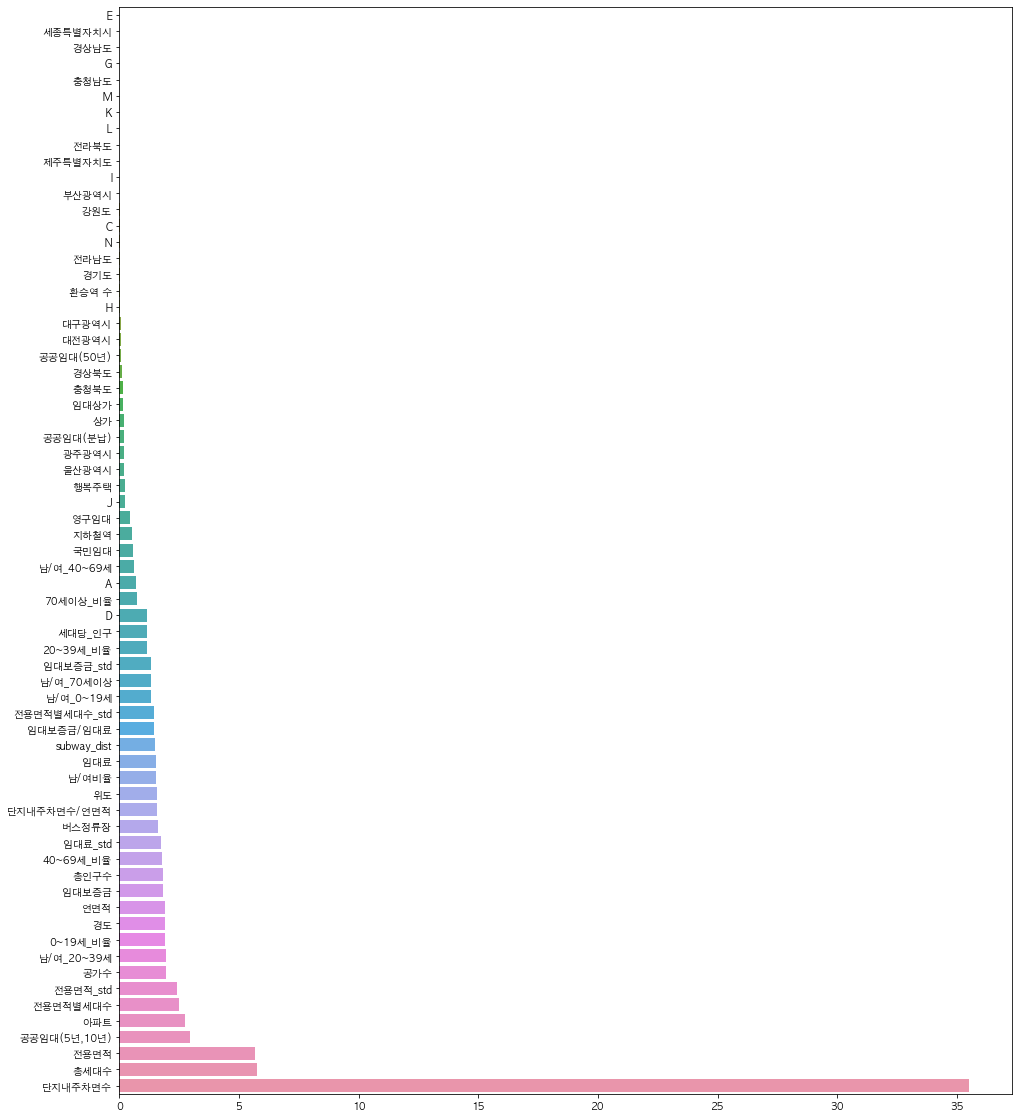

In [85]:
plt.figure(figsize=(16,20))
sns.barplot(y = X.columns[np.argsort(model.feature_importances_)], x = list(model.feature_importances_[np.argsort(model.feature_importances_)]))

plt.show()

## Catboost

In [630]:
from catboost import CatBoostRegressor

In [631]:
model = CatBoostRegressor(
    cat_features = obj_col,
    n_estimators = 200,
    loss_function = 'MAE',
    eval_metric = 'RMSE')

In [632]:
model.fit(X_train, y_train )

0:	learn: 414.1495768	total: 6.53ms	remaining: 1.3s
1:	learn: 408.8728914	total: 10ms	remaining: 991ms
2:	learn: 401.8996464	total: 14.2ms	remaining: 931ms
3:	learn: 397.2645720	total: 17ms	remaining: 832ms
4:	learn: 393.2737502	total: 20.2ms	remaining: 786ms
5:	learn: 388.8313847	total: 22.4ms	remaining: 726ms
6:	learn: 385.1024302	total: 25.8ms	remaining: 710ms
7:	learn: 378.9920330	total: 27.6ms	remaining: 663ms
8:	learn: 375.4380235	total: 29.9ms	remaining: 636ms
9:	learn: 372.5735116	total: 32ms	remaining: 607ms
10:	learn: 367.9386239	total: 33.8ms	remaining: 582ms
11:	learn: 364.8278709	total: 35.8ms	remaining: 561ms
12:	learn: 360.8391424	total: 38.2ms	remaining: 550ms
13:	learn: 355.6649341	total: 40.6ms	remaining: 539ms
14:	learn: 351.0618739	total: 42.9ms	remaining: 529ms
15:	learn: 347.3482061	total: 45.4ms	remaining: 522ms
16:	learn: 342.8073177	total: 48ms	remaining: 517ms
17:	learn: 337.6452539	total: 50ms	remaining: 505ms
18:	learn: 335.6368803	total: 51.9ms	remaining: 4

190:	learn: 135.9028236	total: 394ms	remaining: 18.5ms
191:	learn: 135.6721492	total: 396ms	remaining: 16.5ms
192:	learn: 135.6249031	total: 398ms	remaining: 14.4ms
193:	learn: 135.4259524	total: 400ms	remaining: 12.4ms
194:	learn: 134.9177714	total: 402ms	remaining: 10.3ms
195:	learn: 134.5988827	total: 404ms	remaining: 8.25ms
196:	learn: 134.1526692	total: 406ms	remaining: 6.19ms
197:	learn: 133.1525605	total: 409ms	remaining: 4.13ms
198:	learn: 133.0902882	total: 411ms	remaining: 2.07ms
199:	learn: 132.6913799	total: 414ms	remaining: 0us


In [633]:
tr_pred = model.predict(X_train)
tst_pred = model.predict(X_test)


<AxesSubplot:ylabel='Density'>

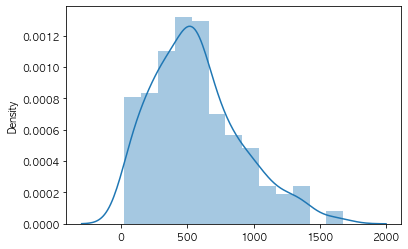

In [634]:
sns.distplot( model.predict(X_train ) )

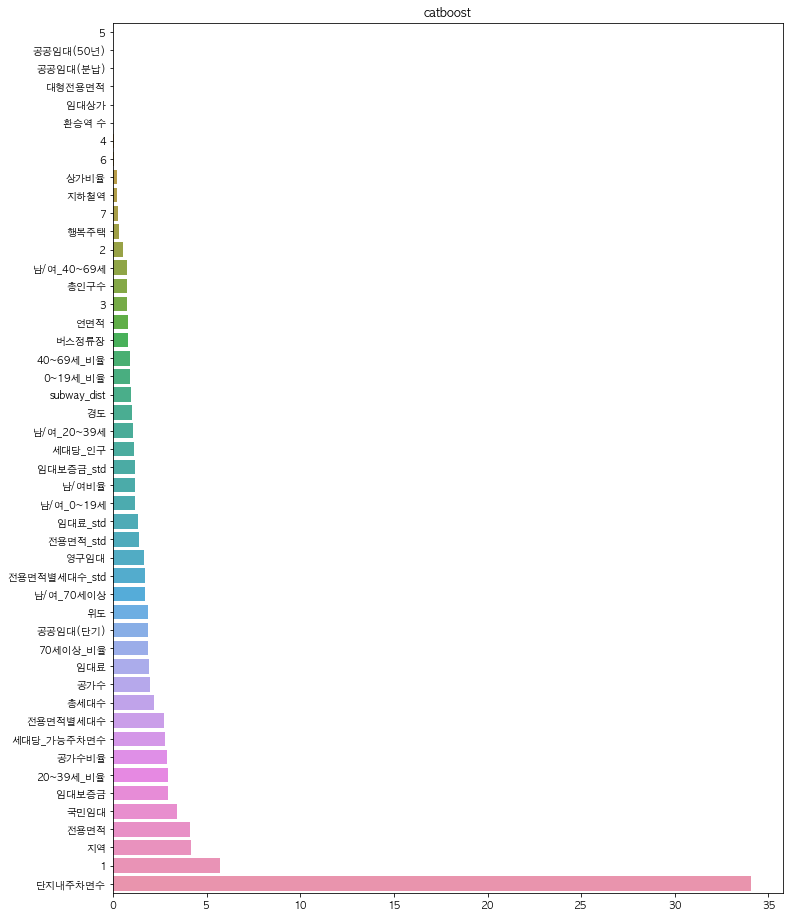

In [641]:
plt.figure(figsize=(12,16))
sns.barplot(y = X.columns[np.argsort(model.feature_importances_)], x = list(model.feature_importances_[np.argsort(model.feature_importances_)]))
plt.title("catboost")
plt.show()

In [636]:
print(mean_absolute_error(y_train,tr_pred ))
print(mean_absolute_error(y_test,tst_pred ))

70.75501398577816
115.89840666215476


In [663]:
tst_res = pd.concat([pd.DataFrame(y_test).reset_index(drop=True),pd.DataFrame(tst_pred)],axis=1)
tst_res.columns = ["tst_y","tst_pred"]
tst_res["ae"] = abs(tst_res["tst_y"] - tst_res["tst_pred"])
tst_res["ae/size"] = tst_res["ae"]/tst_res["tst_y"]
tst_res.sort_values("ae/size",ascending=False)

,tst_y,tst_pred,ae,ae/size
72,19.0000,103.7210,84.7210,4.4590
0,73.0000,368.1828,295.1828,4.0436
64,196.0000,741.0926,545.0926,2.7811
15,376.0000,"1,007.1798",631.1798,1.6787
17,205.0000,529.2933,324.2933,1.5819
14,236.0000,603.4008,367.4008,1.5568
57,207.0000,468.4161,261.4161,1.2629
100,132.0000,271.8588,139.8588,1.0595
97,125.0000,240.8400,115.8400,0.9267
26,235.0000,434.8426,199.8426,0.8504


In [649]:
pd.concat([pd.DataFrame(y_train).reset_index(drop=True),pd.DataFrame(tr_pred)],axis=1)

,등록차량수,0
0,951.0000,800.6781
1,120.0000,107.6935
2,435.0000,504.7523
3,657.0000,846.6158
4,507.0000,587.5796
5,"1,153.0000",964.8991
6,586.0000,570.9549
7,614.0000,704.1462
8,521.0000,520.7311
9,568.0000,531.9410
